In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support,  roc_auc_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [2]:
df = pd.read_csv('/Users/kevinchew/Desktop/p44/P4---West-Nile-Virus/assets/cleaned_datasets/train_weather_weekly.csv')

In [3]:
# Setting the variables
X = df[[col for col in df.columns if col not in ['WnvPresent', 'Year-Week', 'Year', 'Month', 'Week','Species']]]
y = df['WnvPresent']

## Modelling & Hyperparameter Tuning

In this section, we will run hyperparameter tuning for the models chosen. Then, since the data is heavily imbalanced, we will re-fit the model using the over-sampled data, which is obtained using SMOTE and obtain the train and test scores. 



In [4]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2, stratify=y)

### Baseline Prediction

In [5]:
# Look at the proportions of each outcome
y_train.value_counts(normalize=True)

0    0.941245
1    0.058755
Name: WnvPresent, dtype: float64

The data is heavily imbalanced. We will be ~94% accurate if we were to predict all to be the negative class (WNV not present). As such, we will be optimizing our models using AUC score instead of accuracy. We will also deploy SMOTE (Synthetic Minority Over-sampling Technique) to help us with over-sampling.

In [6]:
# Scaling
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [7]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

In [8]:
# Check proportions after SMOTE
ysm_train.value_counts()

0    5687
1    5687
Name: WnvPresent, dtype: int64

The over-sampled data will only be used when evaluating the train and test scores. When we apply GridSearchCV to perform hyperparameter tuning, we will need to utilize an `imblearn.Pipeline` object to handle the imbalanced dataset correctly.

## Fitting Logistic Regression

In [9]:
%%time
# This framework will be the one we use for our modelling

print(f'Fitting Logistic Regression')      # Prints out what model that we are using 

# Set up pipeline
lr_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('lr', LogisticRegression(solver='newton-cg'))
    ])

# Hyperparameters
lr_params = {
    'lr__C': np.linspace(0.1,1,5),
}

# Instantiate 5-fold GridSearchCV.
gs_lr = GridSearchCV(lr_pipe, param_grid = lr_params, cv=5,
                     scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit
gs_lr.fit(Xs_train, y_train)


# See results
print(f'The best parameters are {gs_lr.best_estimator_}.')

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('lr', LogisticRegression(solver='newton-cg'))]).
CPU times: user 539 ms, sys: 85.3 ms, total: 625 ms
Wall time: 5.52 s


Using these best hyperparameters, we will re-fit the model based on the over-sampled data and obtain the scoring metrics

In [10]:
# Re-fit model on over-sampled data
lr = LogisticRegression(solver='newton-cg')
lr.fit(Xsm_train, ysm_train)

LogisticRegression(solver='newton-cg')

In [11]:
# Create list to store all the scores and corresponding model names
model_name = []
model_scores = []
model_var = []
model_test_scores = []


model_name.append('Logistic Regression')
model_scores.append(lr.score(Xsm_train, ysm_train))
model_var.append(lr)
model_test_scores.append(lr.score(Xs_test,y_test))

### Evaluating Logistic Regression Results

#### Let us find the factors/coeffciencts that had the most influence and try to make sense of it

In [12]:
importance = lr.coef_
features = X_train.columns
importance = importance.reshape(lr.coef_.shape[1],1)
imp_lr = pd.DataFrame(importance,
                       index=features,
                       columns=['weights']).sort_values(by='weights', ascending=False)
imp_lr

,weights
Tmax_2,2.170868
NumMosquitos,1.990977
Tavg_1,1.900157
AvgSpeed_2,1.760986
RH_1,1.640499
Tmax_1,1.503653
WetBulb_1,1.421304
Tmin_1,1.260431
Is Wnv Mosquitoes Types,1.235923
SnowFall_1,1.112196


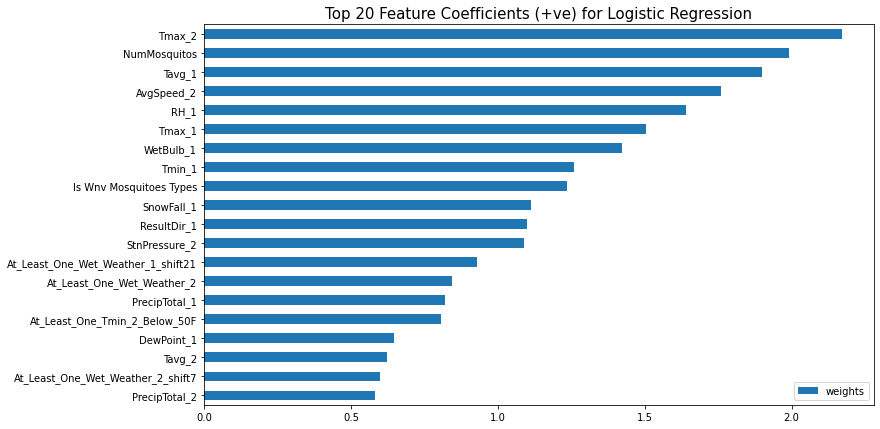

In [13]:
# Plotting top 20 +ve features in bar chart
imp_lr['weights'].head(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (+ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

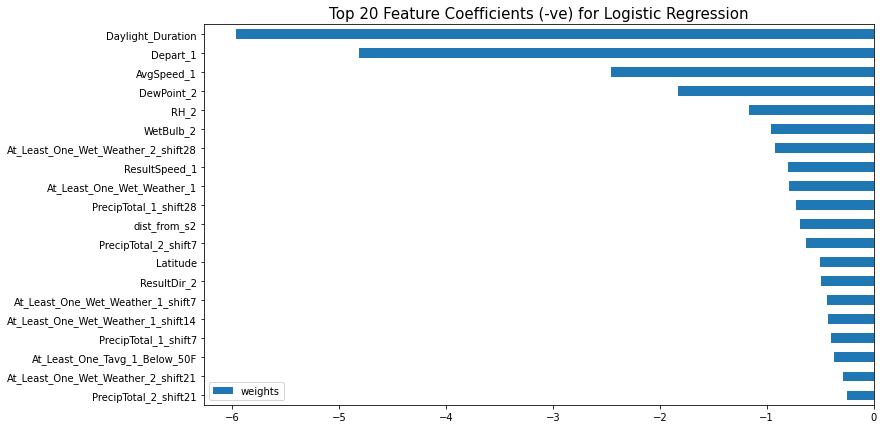

In [14]:
# Plotting top 20 -ve features in bar chart
imp_lr['weights'].tail(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (-ve) for Logistic Regression', fontsize=15)
plt.legend(loc=3);

The plots above display the most important features that contribute to the presence of the Wnv Virus.
According to this [article](https://blog.mosquito.buzz/how-weather-affects-mosquito-activity), weather is a major motivator for what mosquitoes do, and when. This would explain why the top predictors all involve elements that are related to weather. We should also expect the Number of Mosquitoes to be a strong influence as more mosquitoes would mean there is a greater chance that there is a Wnv presence amongst them.

In [15]:
# Get predictions
preds = lr.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/kevinchew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


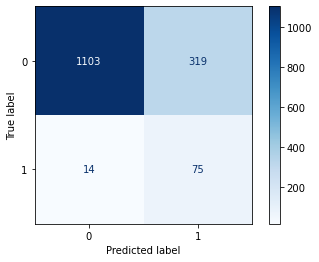

In [16]:
# View confusion matrix

plot_confusion_matrix(lr, Xs_test, y_test, cmap='Blues', values_format='d');

Using Logistic Regression, out of 1511 data points in our test dataset, we classified 1178 (79.96%) correctly. 

## Fitting Naive Bayes

In [17]:
%%time

print(f'Fitting Naive Bayes')      

# Set up pipeline
nb_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('nb', BernoulliNB())
    ])

# Hyperparameters
nb_params = {
    'nb__alpha': [0.9, 1, 1.1]
}

# Instantiate 5-fold GridSearchCV.
gs_nb = GridSearchCV(nb_pipe, param_grid = nb_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_nb.fit(Xs_train, y_train)

# See results
print(f'The best parameters are {gs_nb.best_estimator_}.')

Fitting Naive Bayes
Fitting 5 folds for each of 3 candidates, totalling 15 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('nb', BernoulliNB(alpha=0.9))]).
CPU times: user 89.5 ms, sys: 17 ms, total: 106 ms
Wall time: 320 ms


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [18]:
nb = BernoulliNB(alpha=0.9)
nb.fit(Xsm_train, ysm_train)

BernoulliNB(alpha=0.9)

In [19]:
# Append to the lists
model_name.append('Naive Bayes')
model_scores.append(nb.score(Xsm_train, ysm_train))
model_var.append(nb)
model_test_scores.append(nb.score(Xs_test,y_test)) 

### Evaluating Naive Bayes Results

In [20]:
nb.feature_count_

array([[5448., 2897., 2881.,  877., 3332., 2935., 2885., 3048., 3300.,
        3227.,  203., 1971., 2973., 3187., 2906., 2517., 3089., 3305.,
        3169., 3215., 3121., 2184., 2973., 3429., 3075., 2748., 3290.,
        2755., 2442., 1726., 2146., 1755., 2502., 1771., 2351., 1670.,
        2328., 5321., 5304., 5138., 5105., 5085., 4900., 5195., 5039.,
        5330., 5064.,   63., 1098.,    0.,  764., 2912., 2845.],
       [5687., 3274., 2217., 3879., 3844., 4191., 3848., 3405., 4313.,
        4353.,   22., 2600., 3751., 2285., 3343., 1761., 3515., 4190.,
        3961., 4077., 4059., 2490., 3745., 2743., 3590., 2111., 1644.,
        3378., 2704., 2608., 2644., 2714., 2684., 2352., 2532., 1766.,
        2173., 5266., 4839., 5138., 4928., 5427., 4992., 5619., 5338.,
        5643., 5357.,    0.,  721.,    0.,  473., 3241., 2316.]])

In [21]:
# number of times each feature appear in Wnv NOT present
class0_count = nb.feature_count_[0, :]
class0_count

array([5448., 2897., 2881.,  877., 3332., 2935., 2885., 3048., 3300.,
       3227.,  203., 1971., 2973., 3187., 2906., 2517., 3089., 3305.,
       3169., 3215., 3121., 2184., 2973., 3429., 3075., 2748., 3290.,
       2755., 2442., 1726., 2146., 1755., 2502., 1771., 2351., 1670.,
       2328., 5321., 5304., 5138., 5105., 5085., 4900., 5195., 5039.,
       5330., 5064.,   63., 1098.,    0.,  764., 2912., 2845.])

In [22]:
# number of times each feature appear in Wnv present
class1_count = nb.feature_count_[1, :]
class1_count

array([5687., 3274., 2217., 3879., 3844., 4191., 3848., 3405., 4313.,
       4353.,   22., 2600., 3751., 2285., 3343., 1761., 3515., 4190.,
       3961., 4077., 4059., 2490., 3745., 2743., 3590., 2111., 1644.,
       3378., 2704., 2608., 2644., 2714., 2684., 2352., 2532., 1766.,
       2173., 5266., 4839., 5138., 4928., 5427., 4992., 5619., 5338.,
       5643., 5357.,    0.,  721.,    0.,  473., 3241., 2316.])

In [23]:
# create a DataFrame of features with their separate class counts
features = pd.DataFrame({'feature':X_train.columns, 'Wnv NOT present':class0_count, 'Wnv present':class1_count}).set_index('feature')
features.head()


,Wnv NOT present,Wnv present
feature,,
Is Wnv Mosquitoes Types,5448.0,5687.0
Latitude,2897.0,3274.0
Longitude,2881.0,2217.0
NumMosquitos,877.0,3879.0
Tmax_1,3332.0,3844.0


In [24]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([5687., 5687.])

In [25]:
# Convert the token counts into frequencies
# we add a value of 1 first to prevent divide by zero error
features['Wnv NOT present'] = (features['Wnv NOT present'] + 1) / nb.class_count_[0]
features['Wnv present'] = (features['Wnv present'] + 1) / nb.class_count_[1]

# Calculate the ratio of class-to-class
features['ratio'] = features['Wnv NOT present'] / features['Wnv present']

features.tail()

,Wnv NOT present,Wnv present,ratio
feature,,,
At_Least_One_Tmin_1_Below_50F,0.193248,0.126956,1.522161
At_Least_One_Tavg_2_Below_50F,0.000176,0.000176,1.000000
At_Least_One_Tmin_2_Below_50F,0.134517,0.083348,1.613924
dist_from_s1,0.512221,0.570072,0.898519
dist_from_s2,0.500440,0.407420,1.228312


In [26]:
# examine the DataFrame sorted by ratio
sorted_features = features.sort_values('ratio', ascending=False)

# View the bottom 20 features by ratio
sorted_features.tail(20)

,Wnv NOT present,Wnv present,ratio
feature,,,
ResultDir_1,0.511166,0.588008,0.869318
Tmax_1,0.586074,0.676103,0.866840
ResultDir_2,0.540883,0.631440,0.856586
RH_1,0.484614,0.594162,0.815626
PrecipTotal_2_shift7,0.377528,0.465096,0.811720
Tavg_2,0.557412,0.696677,0.800101
StnPressure_2,0.522947,0.658695,0.793914
StnPressure_1,0.522947,0.659750,0.792644
Tmin_2,0.581326,0.736944,0.788833


The features with the lowest ratio are the ones which contributes the most in classifying the posts into Class 1 (Wnv present). Apart from the more obvious feature (NumMosquitos), we observe that the precipitaton levels at areas affeceted by Station 1 are the next biggest factors. This make sense as rain creates ideal breeding conditions for mosquitoes. More rain means more potential for puddles, and more potential for mosquito breeding.

In [27]:
# View the top 20 features by ratio
sorted_features.head(20)

,Wnv NOT present,Wnv present,ratio
feature,,,
At_Least_One_Tavg_1_Below_50F,0.011254,0.000176,64.000000
SnowFall_1,0.035871,0.004044,8.869565
Daylight_Duration,0.578688,0.289256,2.000608
At_Least_One_Tmin_2_Below_50F,0.134517,0.083348,1.613924
At_Least_One_Tmin_1_Below_50F,0.193248,0.126956,1.522161
AvgSpeed_1,0.442764,0.309829,1.429058
ResultSpeed_1,0.560577,0.401969,1.394576
AvgSpeed_2,0.483383,0.371373,1.301610
Longitude,0.506770,0.390012,1.299369


The features with the highest ratio are the ones which contributes the most in classifying the posts into Class 0 (Wnv not present). 

In [28]:
# Get predictions
preds = nb.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/kevinchew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


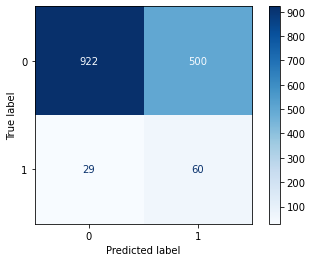

In [29]:
# View confusion matrix

plot_confusion_matrix(nb, Xs_test, y_test, cmap='Blues', values_format='d');

Using Naive Bayes, out of 1511 data points in our test dataset, we classified 982 (64.99%) correctly. 

## Fitting Random Forest Classifier

In [30]:
%%time

print(f'Fitting Random Forest Classifier')   

# Set up pipeline
rf_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])

# Hyperparameters
rf_params = {
    'rf__n_estimators': [80, 100, 120],
    'rf__max_depth': [3, 5],
    'rf__min_samples_leaf': [2, 4],
    'rf__min_samples_split' : [2, 4]
}

# Instantiate 5-fold GridSearchCV.
gs_rf = GridSearchCV(rf_pipe, param_grid = rf_params, cv=5,
                     scoring='roc_auc')

# Fit
gs_rf.fit(Xs_train, y_train)
gs_rf_model = gs_rf.best_estimator_

# See results
print(f'The best parameters are {gs_rf.best_estimator_}.')

Fitting Random Forest Classifier
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=4,
                                        n_estimators=80, random_state=42))]).
CPU times: user 1min 27s, sys: 1.1 s, total: 1min 28s
Wall time: 1min 5s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [31]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=80,
                       random_state=42)
rf.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=80,
                       random_state=42)

In [32]:
# Append to the lists
model_name.append('Random Forest')
model_scores.append(rf.score(Xsm_train, ysm_train))
model_var.append(rf)
model_test_scores.append(rf.score(Xs_test,y_test)) 

### Evaluating Random Forest Results

In [33]:
imp_rf = pd.DataFrame(rf.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights',ascending=False)

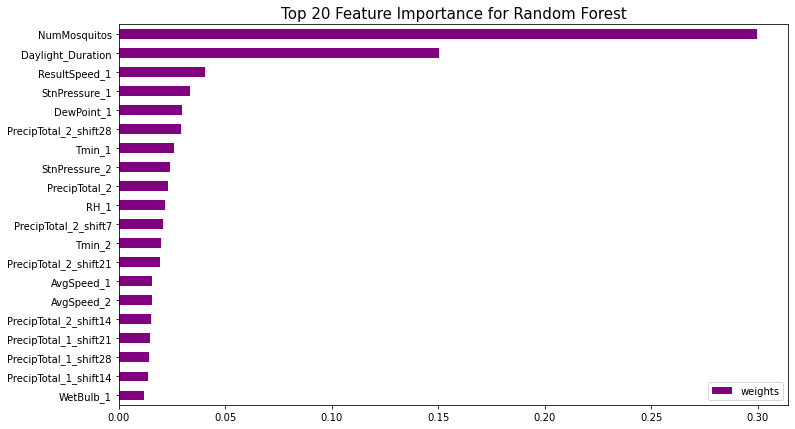

In [34]:
# Plotting Top 20 features in bar chart
imp_rf.head(20).plot(kind='barh', label=imp_rf.columns[:20], figsize=(12,7), color='purple')
plt.title('Top 20 Feature Importance for Random Forest', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

Apart from Number of Mosquitoes, Daylight duration is the next strongest predictor for this model. According to this 
[article](https://blog.mosquito.buzz/how-weather-affects-mosquito-activity), warm evening temperatures allow mosquitoes to thrive, since prolonged sun exposure can actually dehydrate them. 
Also interesting is that Station StnPressure_1 and StnPressure_2 are one of the stronger predictors. According to this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3788776/), there is some evidence that insects adjust their behaviours associated with flight, mating and foraging in response to changes in barometric pressure, which would in turn affect the Wnv Presence. 

In [35]:
# Get predictions
preds = rf.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/kevinchew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


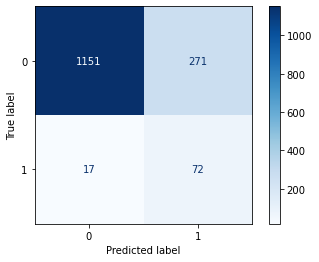

In [36]:
# View confusion matrix

plot_confusion_matrix(rf, Xs_test, y_test, cmap='Blues', values_format='d');

Using Random Forest, out of 1511 data points in our test dataset, we classified 1223 (80.94%) correctly. 


## Fitting ExtraTrees Classifier

In [37]:
%%time

print(f'Fitting Extra Trees')      

# Set up pipeline
et_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('et', ExtraTreesClassifier(random_state=42))
    ])

# Hyperparameters
et_params = {
    'et__n_estimators': [80, 100, 120],
    'et__max_depth': [3, 5],
    'et__min_samples_leaf': [2, 4],
    'et__min_samples_split' : [2, 4]
}

# Instantiate 5-fold GridSearchCV.
gs_et = GridSearchCV(et_pipe, param_grid = et_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_et.fit(Xs_train, y_train)
gs_et_model = gs_et.best_estimator_

# See results
print(f'The best parameters are {gs_et.best_estimator_}.')

Fitting Extra Trees
Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('et',
                 ExtraTreesClassifier(max_depth=5, min_samples_leaf=4,
                                      random_state=42))]).
CPU times: user 846 ms, sys: 47.3 ms, total: 894 ms
Wall time: 18.8 s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [38]:
et = ExtraTreesClassifier(max_depth=5, min_samples_leaf=4,
                     random_state=42)
et.fit(Xsm_train, ysm_train)

ExtraTreesClassifier(max_depth=5, min_samples_leaf=4, random_state=42)

In [39]:
# Append to the lists
model_name.append('ExtraTrees')
model_scores.append(et.score(Xsm_train, ysm_train))
model_var.append(et)
model_test_scores.append(et.score(Xs_test,y_test))

### Evaluating ExtraTrees Results

In [40]:
imp_et = pd.DataFrame(et.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

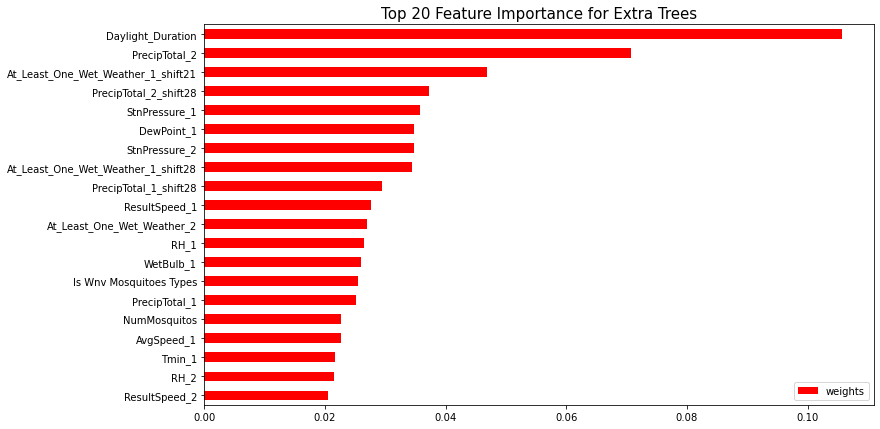

In [41]:
# Top 20 features
imp_et.head(20).plot(kind='barh', label=imp_et.columns, figsize=(12,7), color='red')
plt.title('Top 20 Feature Importance for Extra Trees', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

For this model, Daylight Duration is the strongest predictor. Next is the Species Culex Restuans, which is expected since it is one of the 3 species that were shown to carry the Wnv Virus in the EDA done during the earlier sections. Furthermore, many of the predictors are related to precipitation and wet weather, which is ideal for mosquito breeding. 

In [42]:
# Get predictions
preds = et.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/kevinchew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


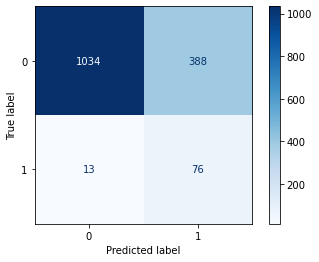

In [43]:
# View confusion matrix

plot_confusion_matrix(et, Xs_test, y_test, cmap='Blues', values_format='d');

Using Extra Trees, out of 1511 data points in our test dataset, we classified 1110 (73.46%) correctly.

### Fitting AdaBoost Classifier

In [44]:
%%time

print(f'Fitting AdaBoost')     

# Set up pipeline
ada_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('ada', AdaBoostClassifier(random_state=42))
    ])

# Hyperparameters
ada_params = {
    'ada__n_estimators': [20, 30, 40, 50],
    'ada__learning_rate': [0.8, 0.9, 1]
}

# Instantiate 5-fold GridSearchCV.
gs_ada = GridSearchCV(ada_pipe, param_grid = ada_params, cv=5,
                      scoring='roc_auc', n_jobs=-1,
                     verbose=1)

# Fit
gs_ada.fit(Xs_train, y_train)
gs_ada_model = gs_ada.best_estimator_

# See results
print(f'The best parameters are {gs_ada.best_estimator_}.')

Fitting AdaBoost
Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.9, random_state=42))]).
CPU times: user 1.15 s, sys: 30.1 ms, total: 1.18 s
Wall time: 14.6 s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [45]:
ada = AdaBoostClassifier(learning_rate=0.9, random_state=42)
ada.fit(Xsm_train, ysm_train)

AdaBoostClassifier(learning_rate=0.9, random_state=42)

In [46]:
# Append to the lists
model_name.append('AdaBoost')
model_scores.append(ada.score(Xsm_train, ysm_train))
model_var.append(ada)
model_test_scores.append(ada.score(Xs_test,y_test))

### Evaluating AdaBoost Results

In [47]:
imp_ada = pd.DataFrame(ada.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

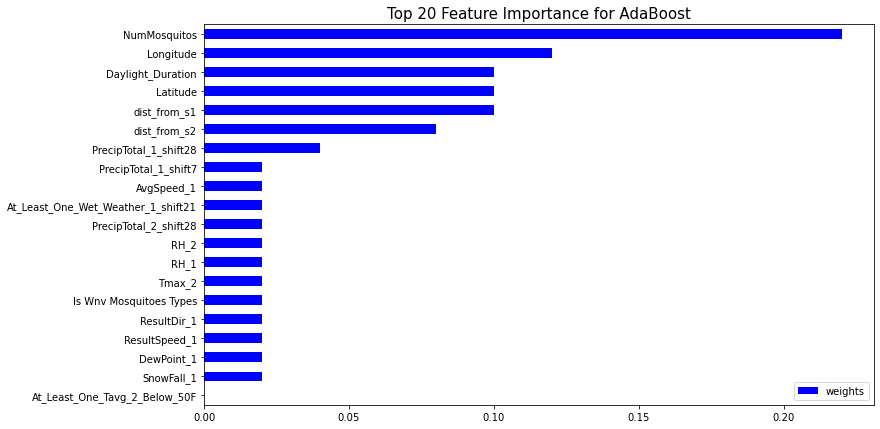

In [48]:
# Plot in bar chart
imp_ada.head(20).plot(kind='barh', label=imp_ada.columns[:20], figsize=(12,7), color='blue')
plt.title('Top 20 Feature Importance for AdaBoost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

In [49]:
# Get predictions
preds = ada.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/kevinchew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


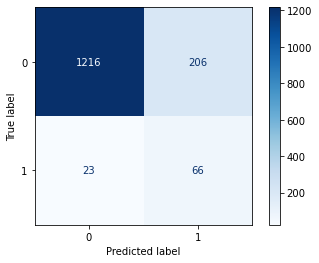

In [50]:
# View confusion matrix

plot_confusion_matrix(ada, Xs_test, y_test, cmap='Blues', values_format='d');

Using Extra Trees, out of 1511 data points in our test dataset, we classified 1282 (84.84%) correctly. 


### Fitting Gradient Boost Classifier

In [51]:
%%time

print(f'Fitting Gradient Boost')     

# Set up pipeline
gboost_pipe = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('gboost', GradientBoostingClassifier())
    ])

# Hyperparameters
gboost_params = {
    'gboost__n_estimators': [80, 100, 120, 150],
    'gboost__max_depth': [1, 2, 3],
    'gboost__min_samples_split': [2, 4],
    'gboost__min_samples_leaf': [1, 2]
}

# Instantiate 5-fold GridSearchCV.
gs_gboost = GridSearchCV(gboost_pipe, param_grid = gboost_params, cv=5,
                         scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit
gs_gboost.fit(Xs_train, y_train)
gs_gboost_model = gs_ada.best_estimator_

# See results
print(f'The best parameters are {gs_gboost.best_estimator_}.')

Fitting Gradient Boost
Fitting 5 folds for each of 48 candidates, totalling 240 fits
The best parameters are Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('gboost',
                 GradientBoostingClassifier(max_depth=1, n_estimators=150))]).
CPU times: user 2.69 s, sys: 93.1 ms, total: 2.78 s
Wall time: 4min 3s


Using these best hyperparameters, we will re-fit the model based on the over-sampleted data and obtain the scoring metrics

In [52]:
gboost = GradientBoostingClassifier(max_depth=1, n_estimators=150)
gboost.fit(Xsm_train, ysm_train)

GradientBoostingClassifier(max_depth=1, n_estimators=150)

In [53]:
# Append to the lists
model_name.append('GradientBooast')
model_scores.append(gboost.score(Xsm_train, ysm_train))
model_var.append(gboost)
model_test_scores.append(gboost.score(Xs_test,y_test)) 

In [54]:
imp_gboost = pd.DataFrame(gboost.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

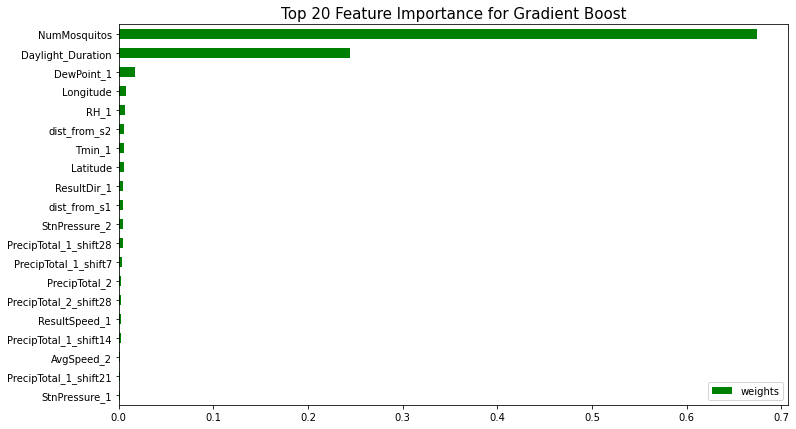

In [55]:
# Plot in bar chart
imp_gboost.head(20).plot(kind='barh', label=imp_gboost.columns[:20], figsize=(12,7), color='green')
plt.title('Top 20 Feature Importance for Gradient Boost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

Number of Mosquitoes and Daylight duration are by far the strongest predictors for this model.

In [56]:
# Get predictions
preds = gboost.predict(Xs_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/kevinchew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


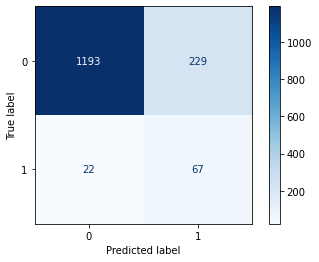

In [57]:
# View confusion matrix

plot_confusion_matrix(gboost, Xs_test, y_test, cmap='Blues', values_format='d');

Using Extra Trees, out of 1511 data points in our test dataset, we classified 1260 (83.39%) correctly. 


### Combining results together

In [58]:
# View the evaluation metrics for all models in a dataframe
# Sorted by highest F1-Score
precision_list = []
recall_list = []
fscore_list = []
auc_list_train = []
auc_list_test = []
for model in model_var:
    y_pred = model.predict(Xs_test)
    y_pred_train = model.predict(Xs_train)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)
    auc_list_train.append(roc_auc_score(y_train, y_pred_train))
    auc_list_test.append(roc_auc_score(y_test, y_pred))

pd.DataFrame({'Model Type': model_name,
              'Train AUC': auc_list_train,
              'Test AUC': auc_list_test,
              'F1-Score': fscore_list,
             'Recall': recall_list,
              'Precision': precision_list,
              'Train Accuracy': model_scores,
             'Test Accuracy': model_test_scores})

,Model Type,Train AUC,Test AUC,F1-Score,Recall,Precision,Train Accuracy,Test Accuracy
0,Logistic Regression,0.823732,0.809182,0.589703,0.809182,0.588911,0.838931,0.779616
1,Naive Bayes,0.680590,0.661270,0.480988,0.661270,0.538324,0.690171,0.649901
2,Random Forest,0.832692,0.809206,0.611068,0.809206,0.597679,0.870406,0.809398
3,ExtraTrees,0.789876,0.790539,0.556225,0.790539,0.575688,0.806401,0.734613
4,AdaBoost,0.824732,0.798353,0.639797,0.798353,0.612042,0.886408,0.848445
5,GradientBooast,0.830380,0.795884,0.626434,0.795884,0.604122,0.872165,0.833885


As earlier stated, we will first use AUC to filter out what model is best for this classficiation problem. This is because AUC works much better for imbalanced dataset.
In this problem, the baseline accuracy is ~94%. This means that, if our model predicts that every point is Wnv NOT present, our accuracy is 94%. Thus, accuracy is not the best metric for validation in this situation.
AUC, on the other hand, utilizes probabilites of class prediction and provides an aggregate measure of performance across all possible classification thresholds. This allows us to be able to more precisely evaluate and compare the models.

Now, from the 'AUC' scores, it is clear that Naive Bayes and Extra Trees are the worst performing models with scores of ~0.70 and ~0.78 respectively. 

Naive Bayes is a classification method based on Bayes' theorem that derives the probability of the given vector being assocaited with a label. it has a naive assumption of conditional independece for every feature, which means that the algorithm expects the features to be independent which is not always the case. Thus, if some of the feautes are in fact dependent on each other, the prediction might be poor. In this classification problem, many of the features are in fact related to each other as several of them are weather related. So, Naive Bayes is not the optimal model for this case and we can eliminate it from our choice.


In [59]:
# Assign the selected production model
production_model = ada

In [60]:
# Save scaler as a pickle file
outfile = open('scaler.pkl','wb')
pickle.dump(ss, outfile)
outfile.close()

In [61]:
# Save model as a pickle file
outfile = open('production_model.pkl','wb')
pickle.dump(production_model, outfile)
outfile.close()

### Preprocessing for Test Dataset

Compared to the train dataset, the test dataset does not have a 'NumMosquitos' column. As seen in the results of our modeling above, NumMosquitoes is an important predictor/feature in determining if the point is WnvPresent or not. Thus, we would do feature engineering to create a 'NumMosquitos' column in the test dataset.

In [62]:
df_train = pd.read_csv('/Users/kevinchew/Desktop/p44/P4---West-Nile-Virus/assets/cleaned_datasets/train_weather_weekly.csv')



In [63]:
# Setting the variables
Xtrain = df_train[[col for col in df_train.columns if col not in ['WnvPresent', 'Year-Week', 'Year', 'Month', 'Week',
                                                         'Species','NumMosquitos']]]
ytrain = df_train['NumMosquitos']

In [64]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, random_state=42, test_size = 0.2)

In [65]:
# Scaling
ss = StandardScaler()
Xss_train = ss.fit_transform(X_train)
Xss_test = ss.transform(X_test)

In [66]:
# Import Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump, load

### Fitting Linear Regression Model

In [67]:
# Fit linear regression model
lr = LinearRegression()
lr.fit(Xss_train,y_train)
lr_pred = np.rint(lr.predict(Xss_test))
print(f"Linear Regression MAE: {mean_absolute_error(y_test,lr_pred)}")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test,lr_pred))}")

Linear Regression MAE: 24.187954996690934
Linear Regression RMSE: 79.27471524077286


### Fitting LassoCV Model

In [68]:
lasso_cv = LassoCV(eps=0.001,n_alphas=100,cv=5,max_iter=1_000_000)
lasso_cv.fit(Xss_train,y_train)
lasso_cv_pred = np.rint(lasso_cv.predict(Xss_test))
print(f"LassoCV best alpha: {lasso_cv.alpha_}")
print(f"LassoCV MAE: {mean_absolute_error(y_test,lasso_cv_pred)}")
print(f"LassoCV RMSE: {np.sqrt(mean_squared_error(y_test,lasso_cv_pred))}")

LassoCV best alpha: 0.009023288475359756
LassoCV MAE: 23.984778292521508
LassoCV RMSE: 79.36665660928942


### Fitting RidgeCV Model

In [69]:
ridge_cv = RidgeCV(alphas=(0.1, 1.0, 10.0))
ridge_cv.fit(Xss_train, y_train)
ridge_cv_pred = np.rint(ridge_cv.predict(Xss_test))
print(f"RidgeCV best alpha: {ridge_cv.alpha_}")
print(f"RidgeCV MAE: {mean_absolute_error(y_test,ridge_cv_pred)}")
print(f"RidgeCV RMSE: {np.sqrt(mean_squared_error(y_test,ridge_cv_pred))}")

RidgeCV best alpha: 1.0
RidgeCV MAE: 23.99735274652548
RidgeCV RMSE: 79.39958340656247


### Selected Model to predict NumMosquitos in Test Dataset : LassoCV

All the 3 models that were used produced good results. If we judge strictly based on the MAE and RMSE score, LassoCV Model performed best as its scores are numerically the lowest. Lasso is a modification of linear regression, where the model is penalized for the sum of absolute values of the weights. It punishes high values of the coefficients and sets them to zero if they are not relevant.

We will use this model to create a 'NumMosquitos' column in the test dataset.

In [70]:
X_scaled = ss.fit_transform(Xtrain)
selected_lasso_cv = LassoCV (eps=0.001, n_alphas=100, cv=5, max_iter=1_000_000) 
selected_lasso_cv.fit(X_scaled, ytrain) # model we use to create 'NumMosquitos' column in test dataset

LassoCV(cv=5, max_iter=1000000)

In [71]:
dump(selected_lasso_cv,'../assets/selected_lasso_cv.joblib')

['../assets/selected_lasso_cv.joblib']

In [72]:
# Import cleaned test dataset
test_weather_weekly = pd.read_csv('/Users/kevinchew/Desktop/p44/P4---West-Nile-Virus/code/test_weather_weekly.csv')

In [73]:
# For species, there is a variable that is not found in the train dataset. This variable is called 'UNSPECIFIED CULEX'
test_weather_weekly['Species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
CULEX ERRATICUS           14345
UNSPECIFIED CULEX         14345
Name: Species, dtype: int64

In [74]:
# Breeds of mosquitoes that carries West Nile Virus
wnv_species = ['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS']

In [75]:
# If Mosquitoes is of the 3 types, Is Wnv Mosquitoes Types is 1
test_weather_weekly['Is Wnv Mosquitoes Types'] = test_weather_weekly['Species'].apply(lambda x: 1 if x in wnv_species else 0)


In [76]:
test_weather_weekly.drop(['Date','Id','Species','AddressAccuracy','Year','Month','Week','Year-Month','Year-Week'],
                        axis=1, inplace=True)

In [77]:
# Load the LassoCV model from earlier
model_to_predict = load('/Users/kevinchew/Desktop/p44/P4---West-Nile-Virus/assets/selected_lasso_cv.joblib')

# Predict NumMosquitos and save as a dataframe
NumMosquitos = pd.DataFrame(data=np.rint(model_to_predict.predict(test_weather_weekly)),columns=['NumMosquitos'])

# Add a new column to the test_clean_wea dataframe
test_weather_weekly = pd.concat([test_weather_weekly,NumMosquitos],axis=1)



/Users/kevinchew/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


In [78]:
df['NumMosquitos'].describe()

count    7553.000000
mean       17.878856
std        83.200195
min         1.000000
25%         2.000000
50%         4.000000
75%        12.000000
max      2582.000000
Name: NumMosquitos, dtype: float64

In [79]:
test_weather_weekly['NumMosquitos'].describe()

count    116293.000000
mean        887.174946
std          11.773817
min         864.000000
25%         879.000000
50%         887.000000
75%         894.000000
max         927.000000
Name: NumMosquitos, dtype: float64

### Kaggle Submission

In [80]:
# Load in production model and scaler
ss = pickle.load(open('scaler.pkl', 'rb'))
model = pickle.load(open('production_model.pkl', 'rb'))

print(ss)
print(model)

StandardScaler()
AdaBoostClassifier(learning_rate=0.9, random_state=42)


In [81]:
# Scale Processed Test Data
Xscaled_test = ss.transform(test_weather_weekly)

/Users/kevinchew/anaconda3/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [82]:
# Get Predictions
predictions = model.predict(Xscaled_test)

In [83]:
# Import original Test Data
original_test = pd.read_csv('/Users/kevinchew/Desktop/p44/P4---West-Nile-Virus/assets/raw_datasets/test.csv')

In [84]:
submission = pd.DataFrame(original_test['Id'])
submission['WnvPresent'] = predictions

In [85]:
submission['WnvPresent'].value_counts()

0    116293
Name: WnvPresent, dtype: int64

In [86]:
# Save csv
submission.to_csv('../assets/submission_predictions.csv', index=False)

![Submission](../images/kaggle_submission_1.png)